In [1]:
import pickle
import os
import argparse
import torch
from jax import random
import json
import datetime
from src.losses import sse_loss
from src.helper import calculate_exact_ggn, tree_random_normal_like, compute_num_params
from src.sampling.predictive_samplers import sample_predictive, sample_hessian_predictive
from jax import numpy as jnp
import jax
from jax import flatten_util
import matplotlib.pyplot as plt
from src.models import LeNet
from src.data import get_rotated_mnist, get_mnist_ood
from src.ood_functions.evaluate import evaluate, evaluate_map
from src.ood_functions.metrics import compute_metrics
from src.data import MNIST
from collections import defaultdict


In [19]:
params = pickle.load(open("../checkpoints/MNIST/LeNet_MNIST_0_params.pickle", "rb"))['params']
proj_samples = pickle.load(open("../checkpoints/posterior_MNIST/Projection_Sampling_MNIST_seed0_params.pickle", "rb"))['posterior_samples']

In [21]:
proj_samples['params']['Conv_0']['kernel'].shape

(30, 5, 5, 1, 6)

In [22]:
model = LeNet(output_dim=10, activation="tanh")
model_fn = model.apply

### R-MNIST

In [23]:
eval_args = {}
eval_args["linearised_laplace"] = True
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):
    _, _, test_loader = get_rotated_mnist(id, data_path="/dtu/p1/hroy/data", download=True, batch_size=ood_batch_size, n_samples_per_class=500)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(test_loader, proj_samples, params, model_fn, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
        all_y_var_in = all_y_var
    more_metrics = compute_metrics(
            i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
        )
    metrics_lr.append({**some_metrics, **more_metrics})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))
    


/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


R-MNIST with distribution shift intensity 0


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.9811, nll: 909.6288, acc: 0.9739, brier: 0.0404, ece: 0.0530, mce: 0.6112


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 1


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.9608, nll: 2302.9368, acc: 0.9350, brier: 0.1022, ece: 0.0857, mce: 0.6441


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 2


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.9097, nll: 9949.3281, acc: 0.7711, brier: 0.3677, ece: 0.2095, mce: 0.3495


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 3


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8232, nll: 50074.9297, acc: 0.2912, brier: 1.1833, ece: 0.5263, mce: 0.7719


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 4


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8121, nll: 79484.2969, acc: 0.1058, brier: 1.5183, ece: 0.6767, mce: 0.9051


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 5


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8233, nll: 75806.2656, acc: 0.1412, brier: 1.4653, ece: 0.6399, mce: 0.8511


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 6


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8440, nll: 71404.3125, acc: 0.2778, brier: 1.2387, ece: 0.5655, mce: 0.7553


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 7


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8815, nll: 73845.5703, acc: 0.3538, brier: 1.1408, ece: 0.5563, mce: 0.7146


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = [0, 15, 30, 60, 90, 120, 150, 180]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_map = []
for i, id in enumerate(ids):
    # params = params_dict['params']
    _, _, test_loader = get_rotated_mnist(id, data_path="/dtu/p1/hroy/data", download=True, batch_size=ood_batch_size, n_samples_per_class=500)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate_map(test_loader, params, model_fn, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
    more_metrics = compute_metrics(
            i, id, all_y_prob, test_loader, all_y_prob_in, all_y_var, benchmark="R-MNIST"
        )
    metrics_map.append({**some_metrics, **more_metrics})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_map[-1].items()]))
    


/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 0


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.9813, nll: 906.7498, acc: 0.9740, brier: 0.0405, ece: 0.0599, mce: 0.6335


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 1


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.9611, nll: 2296.2744, acc: 0.9349, brier: 0.1023, ece: 0.0862, mce: 0.6441


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 2


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.9106, nll: 9930.2070, acc: 0.7706, brier: 0.3685, ece: 0.2110, mce: 0.3486


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 3


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8253, nll: 50018.3008, acc: 0.2914, brier: 1.1859, ece: 0.5280, mce: 0.6928


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 4


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8151, nll: 79405.3750, acc: 0.1060, brier: 1.5223, ece: 0.6790, mce: 0.9053


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 5


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8260, nll: 75736.2188, acc: 0.1410, brier: 1.4688, ece: 0.6427, mce: 0.8565


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 6


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8456, nll: 71371.5156, acc: 0.2784, brier: 1.2405, ece: 0.5656, mce: 0.7459


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()


R-MNIST with distribution shift intensity 7


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


conf: 0.8825, nll: 73832.7500, acc: 0.3535, brier: 1.1421, ece: 0.5573, mce: 0.7149


/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/dtu/p1/hroy/projected-bayes/proj/lib64/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [24]:
import pandas as pd
metrics_dict = ['conf', 'nll', 'acc', 'brier', 'ece', 'mce']
method_list = ["Projected laplace",  "MAP"]
method_dict = {"Laplace Diffusion":metrics_lr, "MAP":metrics_map}
df_data = {metric: ["{:.3f}".format(method_dict[dic][0][metric]) for dic in method_dict] for metric in metrics_dict}
# df_data = {k: ["{:.3f}".format(dic[metric+'_mean']) + u"\u00B1" + "{:.3f}".format(dic[metric+'_std'])  for dic in method_dict[k][1:] for metric in metrics_dict] for k in method_dict}

df = pd.DataFrame.from_dict(df_data, orient='index', columns=method_list)
df = df.T


In [25]:
metrics_lr[0]['nll']

Array(909.62885, dtype=float32)

In [26]:
metrics_map[0]['nll']

Array(906.74976, dtype=float32)

In [27]:
df

,conf,nll,acc,brier,ece,mce
Projected laplace,0.981,909.629,0.974,0.040,0.053,0.611
MAP,0.981,906.750,0.974,0.040,0.060,0.633


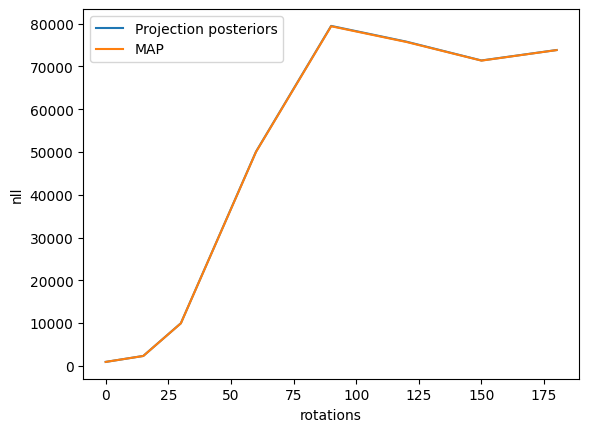

In [28]:
uq_metric = 'nll'
plt.plot(ids, [lr[uq_metric] for lr in metrics_lr], label="Projection posteriors")
plt.plot(ids, [map[uq_metric] for map in metrics_map], label="MAP")

# plt.title(uq_metric)
plt.xlabel("rotations")
plt.ylabel(uq_metric)
plt.legend()

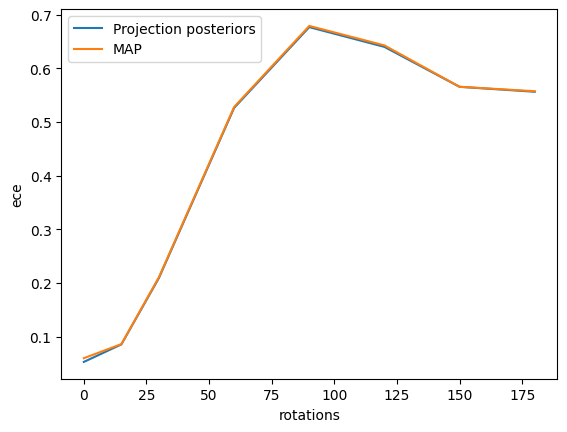

In [29]:
uq_metric = 'ece'
plt.plot(ids, [lr[uq_metric] for lr in metrics_lr], label="Projection posteriors")
plt.plot(ids, [map[uq_metric] for map in metrics_map], label="MAP")

# plt.title(uq_metric)
plt.xlabel("rotations")
plt.ylabel(uq_metric)
plt.legend()

In [ ]:
ood_score = all_y_var.sum(axis=-1)


In [ ]:
from sklearn.manifold import LocallyLinearEmbedding, TSNE, MDS, SpectralEmbedding

In [ ]:
embedding = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')

In [ ]:
train_loader, _, test_loader = get_rotated_mnist(0, data_path="/dtu/p1/hroy/data", download=True, batch_size=500, n_samples_per_class=500)
train_batch = next(iter(train_loader))['image']
test_batch = next(iter(test_loader))['image']
train_transformed = embedding.fit_transform(train_batch.reshape(500, -1))
test_transformed = embedding.fit_transform(test_batch.reshape(500, -1))
ood_loader, _, _ = get_rotated_mnist(180, data_path="/dtu/p1/hroy/data", download=True, batch_size=500, n_samples_per_class=500)
ood_batch = next(iter(ood_loader))['image']
ood_transformed = embedding.fit_transform(ood_batch.reshape(500, -1))

/dtu/p1/hroy/projected-bayes/src/data/mnist.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.nn.functional.one_hot(torch.tensor(self.targets), len(classes)).numpy()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/dtu/p1/hroy/projected-bayes/src/data/mnist.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().require

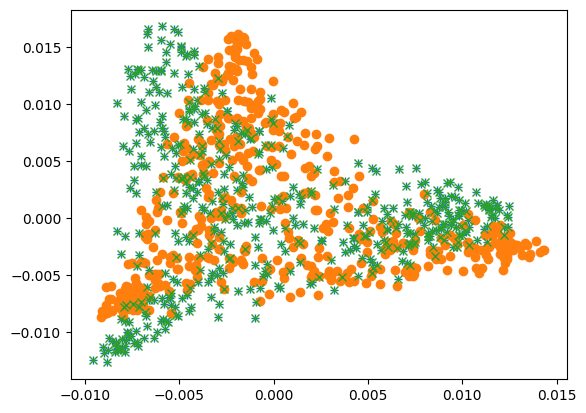

In [ ]:
plt.plot(train_transformed[:, 0], train_transformed[:, 1], '+')
plt.plot(test_transformed[:, 0], test_transformed[:, 1], 'o')
plt.plot(ood_transformed[:, 0], ood_transformed[:, 1], 'x')


In [ ]:
ood_transformed[0]

array([0.01446453, 0.02683621])

In [ ]:
train_transformed[0]

array([0.01446438, 0.02681839])

### OOD MNIST

In [37]:
proj_samples_new = jax.vmap(lambda sample: jax.tree_map(lambda x, y: (x - y) * 5 + y, sample, params))(proj_samples)

In [38]:
import tree_math as tm
print("Mean distance:", jax.vmap(lambda x: (tm.Vector(x) - tm.Vector(params)) @ (tm.Vector(x) - tm.Vector(params))/(tm.Vector(params) @ tm.Vector(params)))(proj_samples).mean())


Mean distance: 0.013950066


In [39]:
print("Mean distance:", jax.vmap(lambda x: (tm.Vector(x) - tm.Vector(params)) @ (tm.Vector(x) - tm.Vector(params))/(tm.Vector(params) @ tm.Vector(params)))(proj_samples_new).mean())


Mean distance: 0.34875146


In [40]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["MNIST", "FMNIST", "KMNIST"]#, 210, 240, 270, 300, 330, 345, 360]
var_dict = {}
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):
    _, train_loader = get_mnist_ood(id, data_path="/dtu/p1/hroy/data", download=True, batch_size=ood_batch_size, n_samples_per_class=500)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate(train_loader, proj_samples_new, params, model_fn, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
        all_y_var_in = all_y_var
    more_metrics = compute_metrics(
            i, id, all_y_prob, train_loader, all_y_prob_in, all_y_var, benchmark="MNIST-OOD"
        )
    metrics_lr.append({**some_metrics, **more_metrics})
    var_dict[id] = all_y_var
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))
    


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


MNIST-OOD - dataset: MNIST
conf: 0.9574, nll: 53.4188, acc: 0.9840


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


MNIST-OOD - dataset: FMNIST
conf: 0.6392, nll: 3451.6982, acc: 0.0900, auroc: 0.9391, fpr95: 0.3540


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


MNIST-OOD - dataset: KMNIST
conf: 0.7216, nll: 4309.9458, acc: 0.0780, auroc: 0.8965, fpr95: 0.4920


In [41]:
from sklearn.metrics import roc_auc_score
import numpy as np
def auroc(scores_id, scores_ood):
    labels = np.zeros(len(scores_id) + len(scores_ood), dtype="int32")
    labels[len(scores_id) :] = 1
    scores = np.concatenate([scores_id, scores_ood])
    return roc_auc_score(labels, scores)

In [44]:
id_score = var_dict["MNIST"].mean(axis=-1)
ood_score = var_dict["FMNIST"].mean(axis=-1)
auroc(id_score, ood_score)

0.936412

In [43]:
eval_args = {}
eval_args["linearised_laplace"] = False
eval_args["posterior_sample_type"] = "Pytree"
eval_args["likelihood"] = "classification"

ids = ["MNIST", "FMNIST", "KMNIST"]#, 210, 240, 270, 300, 330, 345, 360]
n_datapoint=500
ood_batch_size = 50
metrics_lr = []
for i, id in enumerate(ids):
    train_loader, _ = get_mnist_ood(id, data_path="/dtu/p1/hroy/data", download=True, batch_size=ood_batch_size, n_samples_per_class=500)
    some_metrics, all_y_prob, all_y_true, all_y_var = evaluate_map(train_loader, params, model_fn, eval_args)
    if i == 0:
        all_y_prob_in = all_y_prob
        all_y_var_in = all_y_var
    more_metrics = compute_metrics(
            i, id, all_y_prob, train_loader, all_y_prob_in, all_y_var, benchmark="MNIST-OOD"
        )
    metrics_lr.append({**some_metrics, **more_metrics})
    print(", ".join([f"{k}: {v:.4f}" for k, v in metrics_lr[-1].items()]))
    


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


MNIST-OOD - dataset: MNIST
conf: 0.9804, nll: 348.7763, acc: 0.9776


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


MNIST-OOD - dataset: FMNIST
conf: 0.7456, nll: 29612.4375, acc: 0.0942, auroc: 0.9309, fpr95: 0.3664


/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib64/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


MNIST-OOD - dataset: KMNIST
conf: 0.8145, nll: 40214.6016, acc: 0.0700, auroc: 0.8853, fpr95: 0.5016


In [ ]:
train_loader, _ = get_mnist_ood("KMNIST", data_path="/dtu/p1/hroy/data", download=True, batch_size=ood_batch_size, n_samples_per_class=500)

100%|██████████| 18165135/18165135 [00:37<00:00, 486025.29it/s]


Extracting /dtu/p1/hroy/data/KMNIST/raw/train-images-idx3-ubyte.gz to /dtu/p1/hroy/data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 125855.02it/s]


Extracting /dtu/p1/hroy/data/KMNIST/raw/train-labels-idx1-ubyte.gz to /dtu/p1/hroy/data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:04<00:00, 615938.71it/s]


Extracting /dtu/p1/hroy/data/KMNIST/raw/t10k-images-idx3-ubyte.gz to /dtu/p1/hroy/data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 16061956.98it/s]

Extracting /dtu/p1/hroy/data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to /dtu/p1/hroy/data/KMNIST/raw



In [ ]:
train_loader, _ = get_mnist_ood("EMNIST", data_path="/dtu/p1/hroy/data", download=True, batch_size=ood_batch_size, n_samples_per_class=500)

KeyboardInterrupt: 